### Data Loading and Label Mapping

In [1]:
#IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification,pipeline
from googlesearch import search
from bs4 import BeautifulSoup
import requests
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
df = pd.read_csv('Final_Testing_Dataset.csv')
df

In [152]:
df['Label'].value_counts()

label
true     3171
false    3164
Name: count, dtype: int64

<Axes: ylabel='label'>

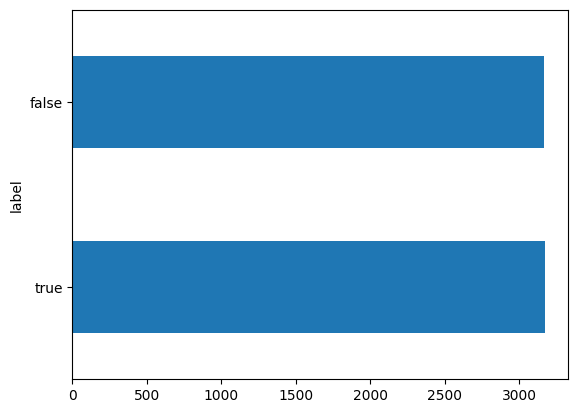

In [153]:
df['Label'].value_counts().plot(kind='barh')

### Articles Pipeline

In [154]:
def get_top_links(query, num_links=1):
    linksgot = []
    try:
        # Perform Google search and get the top links
        search_results = search(query, num_results=num_links)

        # Print the top links
        for i, link in enumerate(search_results, start=1):
            linksgot.append(link)
    except Exception as e:
        print(f"An error occurred: {e}")
    return linksgot


def get_title_and_content(search_query_results):
    article_titles = []
    article_content = []
    if search_query_results:
        for results in search_query_results:
            try:
                # Send a request to the URL and get the HTML content
                response = requests.get(results)
                soup = BeautifulSoup(response.content, 'lxml')

                currentp = ""
                # Scrape <p> tags
                p_tags = soup.find_all('p')
                for p in p_tags:
                    currentp += p.text
                article_content.append(currentp)

                currenth1 = ""
                # Scrape <h1> tags
                h1_tags = soup.find_all('h1')
                for h1 in h1_tags:
                    currenth1 += h1.text

                article_titles.append(currenth1)

            except Exception as e:
                print(f"An error occurred: {e}")
    return article_titles, article_content


# Get the titles and contents
def make_data(search_query_results):
    titles, contents = get_title_and_content(
        get_top_links(search_query_results))

    # Create a pandas DataFrame
    data = {'Title': titles, 'Content': contents}
    df = pd.DataFrame(data)
    return df

In [155]:
#To scrape headlines for the FactCC endpoint
def dataframegen(text_input):
    scraped_df = make_data(text_input)
    scraped_df.dropna(inplace=True)
    return scraped_df

In [156]:
#Load FactCC Model pipeline
pipe = pipeline(model="manueldeprada/FactCC", task="text-classification", max_length=512)

In [157]:
def factCC(input_headline : str):
    scraped_df =  dataframegen(input_headline)

    # Convert the 'Content' column to strings
    scraped_df['Content'] = scraped_df['Content'].astype(str)

    # Sort the DataFrame based on the length of the strings in the 'Content' column
    scraped_df = scraped_df.sort_values(by='Content', key=lambda x: x.str.len(), ascending=False)

    print(f"Title: {scraped_df['Content'][0][:100]}")

    if len(scraped_df) == 0 or not scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Content'][0] or '403 Forbidden' in scraped_df['Title'][0] :
        #Could not retrieve articles related to headline, Could possibly be a false claim OR Scraper got blocked/forbidden
        return False

    scraped_content = (
    f"{scraped_df['Title'][0]} \n{scraped_df['Content'][0]}")
    
    # Perform text classification [source,claim]
    ans = pipe([[[scraped_content,input_headline]]], truncation=True, padding='max_length')

    if ans[0]['label'] == 'CORRECT':
        return True
    else:
        return False

In [158]:
model_decision = factCC(df['Headline'][0])
actual_decision = df['Label'][0]
print(model_decision,actual_decision)
if model_decision == actual_decision:
    print('Correct Decision')
else:
    print('Incorrect Decision')

Title: 
false false
Correct Decision


In [159]:
df = df[:10] #For testing

In [160]:
df

,id,title,text,label
6325,8411,Will the Media Reset After the Election or Are...,Written by Peter Van Buren venerable New Yor...,false
6326,6143,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,DOJ COMPLAINT: Comey Under Fire Over Partisan ...,false
6327,3262,GOP Senator David Perdue Jokes About Praying f...,The freshman senator from Georgia quoted scrip...,true
6328,9337,Radio Derb Is On The Air–Leonardo And Brazil’s...,,false
6329,8737,Assange claims ‘crazed’ Clinton campaign tried...,Julian Assange has claimed the Hillary Clinton...,false
6330,4490,State Department says it can't find emails fro...,The State Department told the Republican Natio...,true
6331,8062,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,The ‘P’ in PBS Should Stand for ‘Plutocratic’ ...,false
6332,8622,Anti-Trump Protesters Are Tools of the Oligarc...,Anti-Trump Protesters Are Tools of the Oligar...,false
6333,4021,"In Ethiopia, Obama seeks progress on peace, se...","ADDIS ABABA, Ethiopia —President Obama convene...",true
6334,4330,Jeb Bush Is Suddenly Attacking Trump. Here's W...,Jeb Bush Is Suddenly Attacking Trump. Here's W...,true


In [164]:
# Initialize lists to store predictions and actual values
predictions = []
actuals = []

# Iterate over each row in the dataframe
for index, row in df.iterrows():
    model_decision = factCC(row['Headline'])
    actual_decision = row['Label']
    predictions.append(model_decision)
    actuals.append(actual_decision)
    print(f"Index: {index}, Model Decision: {model_decision}, Actual Decision: {actual_decision}")
    print(f"------------------------------------------------------------------------------------")

# Calculate the metrics
accuracy = accuracy_score(actuals, predictions)
precision = precision_score(actuals, predictions, pos_label=True)
recall = recall_score(actuals, predictions, pos_label=True)
f1 = f1_score(actuals, predictions, pos_label=True)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')


Title: 403 - Forbidden | Access to this page is forbidden.

Index: 6325, Model Decision: false, Actual Decision: false
------------------------------------------------------------------------------------
Title: An official website of the United States governmentHere's how you know
Official websites use .gov

 
Index: 6326, Model Decision: false, Actual Decision: false
------------------------------------------------------------------------------------
Title: SEARCHThe freshman senator from Georgia quoted scripture at a right-wing Christian confab to say the
Index: 6327, Model Decision: true, Actual Decision: true
------------------------------------------------------------------------------------
Title: 
Index: 6328, Model Decision: false, Actual Decision: false
------------------------------------------------------------------------------------
Title: Campaign escalates charge that WikiLeaks is working with Russian state actors seeking to elect Donal
Index: 6329, Model Decision: false